In [3]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### 1. Overview over dataset and selection of relevant features

The dataset contains the following columns:

`player_id,player_url,fifa_version,fifa_update,fifa_update_date,short_name,long_name,player_positions,overall,potential,value_eur,
wage_eur,age,dob,height_cm,weight_kg,league_id,league_name,league_level,club_team_id,club_name,club_position,
club_jersey_number,club_loaned_from,club_joined_date,club_contract_valid_until_year,nationality_id,nationality_name,
nation_team_id,nation_position,nation_jersey_number,preferred_foot,weak_foot,skill_moves,international_reputation,
work_rate,body_type,real_face,release_clause_eur,player_tags,player_traits,pace,shooting,passing,dribbling,defending,
physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,
skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,
movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,
power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,
mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,
goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,
ls,st,rs,lw,lf,cf,rf,rw,lam,cam,ram,lm,lcm,cm,rcm,rm,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,player_face_url`

We make a fully automated data selection

Reading of data may take some time!

In [24]:
# read data set
dataset = 'male_players.csv'
dataset_df = pd.read_csv(dataset, usecols=['release_clause_eur','value_eur'])
# only take values that are numeric
cleaned_df = dataset_df.select_dtypes(exclude=['object'])
correlation_matrix = cleaned_df.corr()

Check Correlations

In [25]:
def generateData(threshold):


    # choose values that have a correlation that exceeds the threshold
    value_eur_filtered = pd.DataFrame(correlation_matrix.value_eur[(correlation_matrix.value_eur > threshold) | (correlation_matrix.value_eur < (-1*threshold))])

    if(threshold < 0.99):
        value_eur_filtered = value_eur_filtered.drop('release_clause_eur', axis=0)
    
    column_names = value_eur_filtered.index.tolist()
    relevant_attributes_df = dataset_df[column_names].dropna()
    X_as_array = relevant_attributes_df.drop('value_eur', axis=1).values
    y_as_array = relevant_attributes_df['value_eur'].values


    # create heatmap
    sb.set(style="white")
    sb.heatmap(value_eur_filtered.iloc[:, 0:1], annot=True, cmap='coolwarm',  linewidths=.5)

    # plot correlation matrix
    plt.title('Correlation Matrix')
    plt.figure(figsize=(8, 10))
    plt.show()

    return X_as_array, y_as_array

In [26]:
def trainModel(X_as_array, y_as_array):
    # split in test and training data
    X_train, X_test, y_train, y_test = train_test_split(X_as_array, y_as_array, test_size=0.2, random_state=42)
    print(X_test.shape)
    print(y_test.shape)
    print(X_train.shape)
    print(y_train.shape)

    # create linear regression
    model = LinearRegression()
    model.fit(X_train, y_train)

    # predict test data
    y_pred = model.predict(X_test)

    # evaluate model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return(mse, r2)

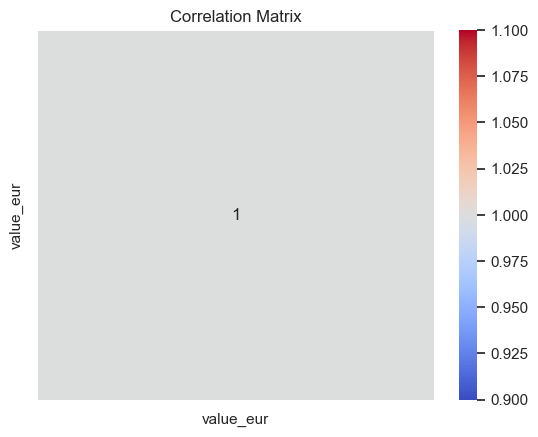

<Figure size 800x1000 with 0 Axes>

(1974159, 0)
(1974159,)
(7896634, 0)
(7896634,)


ValueError: Found array with 0 feature(s) (shape=(7896634, 0)) while a minimum of 1 is required by LinearRegression.

In [27]:
x,y = generateData(0.3)
print(trainModel(x,y))

# 2. Other Models
Let's try out different evaluation algorithms to compare accuracy.

Regression trees:


In [1]:
# import the regressor 
from sklearn.tree import DecisionTreeRegressor  
  
# create a regressor object 
regressor = DecisionTreeRegressor(random_state = 0)  
  
# fit the regressor with X and Y data 
regressor.fit(X_train, y_train) 

#test the regressor
y_reg = regressor.predict([X_test])

#accuracy on test set
rt_accuracy = accuracy_score(y_test, y_reg)
print(f'Test accuracy {rt_accuracy}')




NameError: name 'X_train' is not defined

Random forest with Regression tree:

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

Check for and handle categorical variables
label_encoder = LabelEncoder()
x_categorical = dataset_df.select_dtypes(include=['object']).apply(label_encoder.fit_transform)
x_numerical = dataset_df.select_dtypes(exclude=['object']).values
x = pd.concat([pd.DataFrame(x_numerical), x_categorical], axis=1).values

# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)

# Fit the regressor with x and y data
regressor.fit(x, y)
